In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
myfontsize=20
plt.rcParams.update({'font.size': myfontsize})
import numpy as np
import astropy.io.fits as fits
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,ScalarFormatter, NullFormatter
from scipy import stats
from sklearn.linear_model import LinearRegression
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
import sys
sys.path.insert(1,'/Users/lalitwadee/HSC_project/Morphology/PDR2')
from util_sample_selection import *
parent_dir='/Users/lalitwadee/HSC_project/Morphology/PDR2/'
from util_sample_selection import *
from util_nancy import *
from util_sizemass import *
from readcat_pdr2 import *
import dynesty
from dynesty.utils import resample_equal
from dynesty import NestedSampler

from scipy.stats import gaussian_kde
from concurrent.futures import ThreadPoolExecutor,\
                               ProcessPoolExecutor
from multiprocessing import Pool, cpu_count
from scipy.special import ndtri
npz_contam= np.load('%sdud/lmass_contamfrac_UltraVISTA.npz' % parent_dir)
from matplotlib.lines import Line2D
with open('%smass_comp_24.5mag_90complete.pkl' % parent_dir, 'rb') as buff:
    data_mcomp_deep = pickle.load(buff)
redshiftbins=[0.2,0.4,0.6,0.8,1.0]
import matplotlib.patheffects as path_effects
# for HSC (grizy)
g_lambda=  4798.2
r_lambda=  6218.4
i_lambda=  7727.0
z_lambda=  8908.2
y_lambda=  9775.1
add_sys_err=True
add_catastrophic_z=True #True

In [3]:
def func_logre_logmass(lmass,slope,intercept):
    return intercept+slope*(lmass-10.0)

def fit_colorgrad_mass(redshiftbins=None,lmassbins=None,color_gradient_slope=None):#,ax=None,plot_kwargs=None):
    redshiftbinctrs=redshiftbins[:-1]+(redshiftbins[1:]-redshiftbins[:-1])/2.0
    lmassbinctrs =lmassbins[:-1]+(lmassbins[1:]-lmassbins[:-1])/2.0
    X = np.zeros( (  (len(redshiftbins)-1)* (len(lmassbins)-1),2) )
    Y=np.zeros((len(redshiftbins)-1)* (len(lmassbins)-1))
    sample_weight = np.zeros((len(redshiftbins)-1)* (len(lmassbins)-1))
    k=0
    for i in range(len(redshiftbinctrs)):
        for j in range(len(lmassbinctrs)):
            X[k,0]=redshiftbinctrs[i]
            X[k,1]=lmassbinctrs[j] -10   # normalize M by 10^10
            Y[k] = color_gradient_slope[i,j,0]
            yerr= ((color_gradient_slope[i,j,1])+ (color_gradient_slope[i,j,2]))/2.0
            sample_weight[k]= 1/(yerr**2)
            k=k+1
    regressor = LinearRegression(normalize=True)
    regressor.fit(X, Y,sample_weight)
    score=regressor.score(X, Y,sample_weight)
    #return X,Y,sample_weight
    return regressor.intercept_, regressor.coef_[0],regressor.coef_[1],score

In [9]:
import corner 
def plotposts(samples=None,labels=None,fig_name=None): #**kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    #if "truths" not in kwargs:
    #    kwargs["truths"] = [m, c]

    fig = corner.corner(samples, labels=labels, hist_kwargs={'density': True})#, **kwargs)
    fig.savefig('%s.png' %  fig_name,dpi=100)

In [12]:
def get_logre_totalerr(band=None,tbdata=None):
    scale= tbdata.field('scale_kpc_per_arcsec')
    logre_syserr = get_logre_syserr(tbdata.field('imag'))
    re_syserr = logre_syserr* np.log(10)*tbdata.field('fitted_reff_%s' % band )*scale
    re_totalerr = np.sqrt( np.power(tbdata.field('fitted_reff_err')*scale,2)+ np.power(re_syserr,2)  )
    log_re_totalerr = re_totalerr /(tbdata.field('fitted_reff_%s' % band )*scale * np.log(10))
    return log_re_totalerr
hdulist=fits.open('/Users/lalitwadee/HSC_project/Morphology/PDR2/dud/multibands/ud_pdr2_0.2z1.0_wEAZY_wstructure_goodfits_allbands.fits') 
_tbdata=hdulist[1].data
hdulist.close()
sigma_res_thres=0.03
median_res_thres= 0.05


t=(np.where( (_tbdata.field('imag') < 25) 
        & (_tbdata.field('median_residual_g') < median_res_thres) & (_tbdata.field('sigma_residual_g') < sigma_res_thres)
        & (_tbdata.field('median_residual_r') < median_res_thres) & (_tbdata.field('sigma_residual_r') < sigma_res_thres)
        & (_tbdata.field('median_residual_i') < median_res_thres) & (_tbdata.field('sigma_residual_i') < sigma_res_thres)
        & (_tbdata.field('median_residual_z') < median_res_thres) & (_tbdata.field('sigma_residual_z') < sigma_res_thres)
        &(_tbdata.field('median_residual_y') < median_res_thres) & (_tbdata.field('sigma_residual_y') < sigma_res_thres) 
        & (_tbdata.field('fitted_reff_g')>0) & (_tbdata.field('fitted_reff_r')>0) & (_tbdata.field('fitted_reff_i')>0) 
        &  (_tbdata.field('fitted_reff_z')>0) & (_tbdata.field('fitted_reff_y')>0)))[0]


tbdata= _tbdata[t]
print(len(_tbdata),len(tbdata))
zphot =tbdata.field('photoz_best')
logmstar =  np.log10(tbdata.field('stellar_mass'))
rz_color= -2.5*np.log10( tbdata.field('sdss_rflux_rest_eazy')/ tbdata.field('sdss_zflux_rest_eazy') )
ur_color =-2.5*np.log10( tbdata.field('sdss_uflux_rest_eazy') / tbdata.field('sdss_rflux_rest_eazy')  )
qui_index,sf_index,quiescent_flag = colorcolorsel_urz(rz_color,ur_color,zphot)

scale= tbdata.field('scale_kpc_per_arcsec')

re_allwl = (np.dstack([tbdata.field('fitted_reff_g')*scale,tbdata.field('fitted_reff_r')*scale,
                       tbdata.field('fitted_reff_i')*scale,tbdata.field('fitted_reff_z')*scale,
                       tbdata.field('fitted_reff_y')*scale]))[0]



if (add_sys_err==True):
    print('add sys err')
    logre_err_allwl=(np.dstack([get_logre_totalerr(band='g',tbdata=tbdata),get_logre_totalerr(band='r',tbdata=tbdata),
     get_logre_totalerr(band='i',tbdata=tbdata),get_logre_totalerr(band='z',tbdata=tbdata),
     get_logre_totalerr(band='y',tbdata=tbdata)]))[0]
if (add_sys_err==False):
    print('does not add sys err')
    logre_err_allwl=(np.dstack([tbdata.field('fitted_reff_err')/(np.log(10)*tbdata.field('fitted_reff_g')),
                                tbdata.field('fitted_reff_err')/(np.log(10)*tbdata.field('fitted_reff_r')),
                                tbdata.field('fitted_reff_err')/(np.log(10)*tbdata.field('fitted_reff_i')),
                                tbdata.field('fitted_reff_err')/(np.log(10)*tbdata.field('fitted_reff_z')),
                                tbdata.field('fitted_reff_err')/(np.log(10)*tbdata.field('fitted_reff_y'))]))[0]
#re_err = tbdata.field('fitted_reff_err')*scale
imag=tbdata.field('imag')
cmodelmag_allwl = (np.dstack([np.ones(len(t))*imag, np.ones(len(t))*imag,
                             np.ones(len(t))*imag,np.ones(len(t))*imag,np.ones(len(t))*imag]))[0]

zphot_allwl= (np.dstack([np.ones(len(t))*zphot, np.ones(len(t))*zphot,
                             np.ones(len(t))*zphot,np.ones(len(t))*zphot,np.ones(len(t))*zphot]))[0]

logmstar_allwl = (np.dstack([np.ones(len(t))*logmstar, np.ones(len(t))*logmstar,
                             np.ones(len(t))*logmstar,np.ones(len(t))*logmstar,np.ones(len(t))*logmstar]))[0]
fwhm_allwl = (np.dstack([tbdata.field('g_convolvedflux_seeing')*2.355,tbdata.field('r_convolvedflux_seeing')*2.355,
                       tbdata.field('i_convolvedflux_seeing')*2.355,tbdata.field('z_convolvedflux_seeing')*2.355,
                       tbdata.field('y_convolvedflux_seeing')*2.355]))[0]


print(np.shape(re_allwl), np.shape(logre_err_allwl), np.shape(zphot_allwl),np.shape(logmstar_allwl))


obs_lambda_all = (np.dstack([np.ones(len(t))*g_lambda, np.ones(len(t))*r_lambda,
                             np.ones(len(t))*i_lambda,np.ones(len(t))*z_lambda,np.ones(len(t))*y_lambda]))[0]

rest_lambda_all=(np.dstack([np.ones(len(t))*g_lambda/(1+zphot), np.ones(len(t))*r_lambda/(1+zphot),
                            np.ones(len(t))*i_lambda/(1+zphot),np.ones(len(t))*z_lambda/(1+zphot),
                            np.ones(len(t))*y_lambda/(1+zphot)]))[0]
print(np.shape(obs_lambda_all),np.shape(rest_lambda_all))

print(np.shape(zphot_allwl))

389745 107070
add sys err
(107070, 5) (107070, 5) (107070, 5) (107070, 5)
(107070, 5) (107070, 5)
(107070, 5)


In [ ]:

def draw_cut(ax=None,A=1.5,zp=1, hcut=1.9,vcut=1.1):
    # from Holden et al. 2012
    #A=2.5
    #zp=0.76
   
    #vcut2= (1.5-zp)/A
    minX,maxX,minY,maxY=0,1,0,3
    xbins=np.arange(minX,maxX,0.1)
    ybins = np.arange(minY,maxY,0.2)
    maxX_intersect=(hcut-zp)/A
    x_arr = np.arange(maxX_intersect,vcut+0.1,0.1)
    maxY_intercept= A*vcut+zp
    x_ = np.linspace(0,vcut,50,endpoint=True)
    x_ = np.hstack([x_,np.ones(10)*vcut  ])
    x__ = np.linspace(0,1,50,endpoint=True)
    # draw traditional UVJ cut
    ax.plot(x_,uvj_boundary_func(x_,hcut=hcut,vcut=vcut,A=A,zp=zp),color='k',zorder=10)#,lw=3)


fig,ax=plt.subplots(figsize=(5,5),dpi=100)
levels = 1.0 - np.exp(-0.5 * np.arange(1, 3.1, 0.5) ** 2)
smooth_sigma=2
fraction_datapoints=0.01
min_x,max_x= 0.,1.6
min_y,max_y = 0.,3
range_value = [[min_x,max_x], [min_y,max_y]] 

xbins=np.arange(min_x,max_x,0.04)
ybins=np.arange(min_y,max_y,0.04)
#print(r_z)
#print(u_r)
sigmacontour_dict= plot_sigmacontour(rz_color,ur_color,yerr=None,uplims=None,
                             levels=levels,range_value=range_value,ax=ax,
                             bins= [xbins,ybins],smooth=smooth_sigma, 
                             color='grey',no_fill_contours =False,
                             fill_contours=False,plot_contours=True,plot_datapoints=False,
                             plot_density=True,fraction_datapoints=fraction_datapoints)


#ax.scatter( r_z,u_r,s=0.1,c=lssfr,vmin=-14,vmax=-8,alpha=0.1,rasterized=True)

ax.set_xlim(min_x,max_x)
ax.set_ylim(min_y,max_y)
ax.set_xlabel(r'$(r-z)_{\mathrm{rest}}$')
ax.set_ylabel(r'$(u-r)_{\mathrm{rest}}$')

ax.scatter(rz_color[qui_index],ur_color[qui_index],color='r',s=0.1,alpha=0.1)
ax.scatter(rz_color[sf_index],ur_color[sf_index],color='b',s=0.1,alpha=0.1)
draw_cut(ax=ax,A=0.86,zp=1.44,hcut=1.92,vcut=1.4)


    

In [11]:
def func_logre_loglambda(x,slope,intercept):
    return slope*x+intercept
def fit_logRe_lambda(redshiftmin=None,redshiftmax=None,lmassmin=None,lmassmax=None, run_dynesty=True, tol =1,
                    SMFweight=True,use_contamfrac=True):
    tt_sf = (np.where(  (zphot[sf_index] > redshiftmin) &  (zphot[sf_index] <= redshiftmax) & 
                                 (logmstar[sf_index] >lmassmin) & (logmstar[sf_index] <=lmassmax)   ))[0]
    tt_qui = (np.where(  (zphot[qui_index] > redshiftmin) &  (zphot[qui_index] <= redshiftmax) & 
                                 (logmstar[qui_index] >lmassmin) & (logmstar[qui_index] <=lmassmax)   ))[0]
    z_qui =(zphot_allwl[qui_index,:])[tt_qui].reshape(-1)
    lmass_qui = (logmstar_allwl[qui_index,:])[tt_qui].reshape(-1)
    loglambda_qui = np.log10((rest_lambda_all[qui_index,:])[tt_qui].reshape(-1))
    logre_qui = np.log10((re_allwl[qui_index,:])[tt_qui].reshape(-1))
    logre_err_qui = (logre_err_allwl[qui_index,:])[tt_qui].reshape(-1)
    imag_qui = (cmodelmag_allwl[qui_index,:])[tt_qui].reshape(-1)
#     z_qui = (zphot_allwl[qui_index[tt_qui],:]).reshape(-1)
#     lmass_qui =(logmstar_allwl[qui_index[tt_qui],:]).reshape(-1)
#     loglambda_qui = (np.log10(rest_lambda_all[qui_index[tt_qui]])).reshape(-1)
#     logre_qui = (np.log10(re_allwl[qui_index[tt_qui],:])).reshape(-1)
#     logre_err_qui = (logre_err_allwl[qui_index[tt_qui],:]).reshape(-1)
    
#     imag_qui = (cmodelmag_allwl[qui_index[tt_qui],:]).reshape(-1) 
    #re_err_qui =re_err[qui_index[tt_qui],:]
    
    z_sf =(zphot_allwl[sf_index,:])[tt_sf].reshape(-1)
    lmass_sf = (logmstar_allwl[sf_index,:])[tt_sf].reshape(-1)
    loglambda_sf = np.log10((rest_lambda_all[sf_index,:])[tt_sf].reshape(-1))
    logre_sf = np.log10((re_allwl[sf_index,:])[tt_sf].reshape(-1))
    logre_err_sf = (logre_err_allwl[sf_index,:])[tt_sf].reshape(-1)
    imag_sf = (cmodelmag_allwl[sf_index,:])[tt_sf].reshape(-1)
    #print(np.shape(z_qui),np.shape(lmass_qui),np.shape(loglambda_qui), np.shape(logre_qui),np.shape(logre_err_qui))
    #print(np.shape(z_sf),np.shape(lmass_sf),np.shape(loglambda_sf), np.shape(logre_sf),np.shape(logre_err_sf))

    #re_err_sf =re_err[sf_index[tt_sf],:]
    if (add_catastrophic_z==True):
        print('incorporate catastrophic redshift')
        Catas_qui = compute_catastrophic_redshift(z_qui,imag_qui,galtype='all')
        Catas_sf = compute_catastrophic_redshift(z_sf,imag_sf,galtype='all')
        print('Catas_qui',Catas_qui)
        print('Catas_sf',Catas_sf)
    if (use_contamfrac==True):         
        print('Account for contamination fraction')
        C_qui = get_contamfrac(z_qui,lmass_qui,npz_contam=npz_contam,galtype='qui')
        C_sf = get_contamfrac(z_sf,lmass_sf,npz_contam=npz_contam,galtype='sf')
        #print('C_qui',C_qui)
        #print('C_sf',C_sf)
    if (use_contamfrac==False):        
        print('Not account for contamination fraction')
        C_qui = np.zeros(len(lmass_qui))
        C_sf =np.zeros(len(lmass_sf))
    if (SMFweight==True):
        print('Apply weights by number density')
        W_qui= compute_weights(lmass_qui,z_qui,galtype='qui')  
        W_sf= compute_weights(lmass_sf,z_sf,galtype='sf') # 
    if (SMFweight==False):
        print('Not weighted by number density')
        W_qui =np.ones(len(lmass_qui))   # # assuming equal weight
        W_sf= np.ones(len(lmass_sf)) 
    def prior_transform(theta):
        slope_qui_prime,intercept_qui_prime,lnV_qui_prime,slope_sf_prime,intercept_sf_prime,lnV_sf_prime=theta
        slope_min,slope_max=-1.5,1.5
        lnV_min,lnV_max=-6.5,0
        intercept_min,intercept_max=-3,4
        slope_qui = slope_qui_prime*(slope_max-slope_min)+slope_min
        slope_sf = slope_sf_prime*(slope_max-slope_min)+slope_min
        
        intercept_qui = intercept_qui_prime*(intercept_max-intercept_min)+intercept_min
        intercept_sf = intercept_sf_prime*(intercept_max-intercept_min)+intercept_min
        
        lnV_qui = lnV_qui_prime*(lnV_max-lnV_min)+ lnV_min
        lnV_sf = lnV_sf_prime*(lnV_max-lnV_min)+ lnV_min
        return (slope_qui,intercept_qui,lnV_qui,slope_sf,intercept_sf,lnV_sf)
    def loglikelihood_dynesty(theta):
        slope_qui,intercept_qui,lnV_qui,slope_sf,intercept_sf,lnV_sf=theta
        V_qui = np.exp(lnV_qui)
        V_sf = np.exp(lnV_sf)
        Qui_dy_qui = logre_qui- func_logre_loglambda(loglambda_qui,slope_qui,intercept_qui)
        Qui_dy_sf = logre_qui- func_logre_loglambda(loglambda_qui,slope_sf,intercept_sf)
        
        SF_dy_qui = logre_sf- func_logre_loglambda(loglambda_sf,slope_qui,intercept_qui)
        SF_dy_sf = logre_sf- func_logre_loglambda(loglambda_sf,slope_sf,intercept_sf)
        
        ivar_qui= 1 / (logre_err_qui**2 + V_qui) # inverse-variance now includes intrinsic scatter
        Qui_P_qui = np.sqrt((1/(2*np.pi)) *ivar_qui)*  np.exp(-0.5*   Qui_dy_qui**2 * ivar_qui   )
        Qui_P_sf = np.sqrt((1/(2*np.pi)) *ivar_qui)*  np.exp(-0.5*   Qui_dy_sf**2 * ivar_qui   )
        if (add_catastrophic_z==False):
            ln_like_qui = np.sum(np.log(W_qui*((1-C_qui)*Qui_P_qui + C_qui*Qui_P_sf+0.01)))
        if (add_catastrophic_z==True):
            ln_like_qui = np.sum(np.log(W_qui*((1-C_qui)*Qui_P_qui + C_qui*Qui_P_sf+Catas_qui)))
        #For SF
        ivar_sf= 1 / (logre_err_sf**2 + V_sf) # inverse-variance now includes intrinsic scatter
        SF_P_qui = np.sqrt((1/(2*np.pi)) *ivar_sf)*  np.exp(-0.5*   SF_dy_qui**2 * ivar_sf   )
        SF_P_sf = np.sqrt((1/(2*np.pi)) *ivar_sf)*  np.exp(-0.5*   SF_dy_sf**2 * ivar_sf   )
        if (add_catastrophic_z==False):
            ln_like_sf = np.sum(np.log(W_sf*((1-C_sf)*SF_P_sf + C_sf*SF_P_qui+0.01)))
        if (add_catastrophic_z==True):
            ln_like_sf = np.sum(np.log(W_sf*((1-C_sf)*SF_P_sf + C_sf*SF_P_qui+Catas_sf)))
        return ln_like_qui+ ln_like_sf 
    def plot_logsize_loglambda(ndim,samples_dynesty=None,fig_name=None):
        fig,ax= plt.subplots(figsize=(6,5),dpi=100)
        min_x,max_x=np.log10(np.min(rest_lambda_all)), np.log10(np.max(rest_lambda_all))
        min_y,max_y= -0.5,2
        x_arr =np.linspace(min_x,max_x,100 )
        ax.scatter(loglambda_qui,logre_qui,rasterized=True,alpha=0.1,s=0.5,color='crimson')
        ax.scatter(loglambda_sf,logre_sf,rasterized=True,alpha=0.1,s=0.5,color='royalblue')
        if (samples_dynesty is not None):
            for slope_qui,intercept_qui,lnV_qui,slope_sf,intercept_sf,lnV_sf in samples_dynesty[np.random.randint(len(samples_dynesty), size=100)]:
                ax.plot(x_arr,func_logre_loglambda(x_arr,slope_qui,intercept_qui), color="r", alpha=0.1)
                ax.plot(x_arr, func_logre_loglambda(x_arr,slope_sf,intercept_sf), color="b", alpha=0.1)
        ax.set_xlabel(r'$\log (\lambda_{\mathrm{rest}}/$Angstrom)')
        ax.set_ylabel(r'$\log (r_{e}/\mathrm{kpc})$')
        ax.set_xlim(min_x,max_x)
        #ax.set_ylim(min_y,max_y)
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        if (use_contamfrac==True):         
            fig.savefig('logRe_loglambda_%.1fz%.1f_%.1flmass%.1f.png' % (redshiftmin,redshiftmax, lmassmin,lmassmax),dpi=100)
        if (use_contamfrac==False):         
            fig.savefig('logRe_loglambda_%.1fz%.1f_%.1flmass%.1f_nocontamfrac.png' % (redshiftmin,redshiftmax, lmassmin,lmassmax),dpi=100)
    ndims=6
    nlive = 1024      # number of live points
    bound = 'multi'   # use MutliNest algorithm for bounds
    sample = 'rwalk'#'unif' #'unif'   # uniform sampling
    if (run_dynesty==True):
        with ThreadPoolExecutor(max_workers=cpu_count()-1) as executor:
            sampler = NestedSampler(loglikelihood_dynesty, prior_transform, ndims,
                    bound=bound, sample=sample, nlive=nlive,pool=executor,queue_size=cpu_count())
            #t0 = time()
            sampler.run_nested(dlogz=tol, print_progress=True)
            res = sampler.results # get results dictionary from sampler
        logZdynesty = res.logz[-1]        # value of logZ
        logZerrdynesty = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ
        print("log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))
        resdict={}
        # draw posterior samples
        weights = np.exp(res['logwt'] - res['logz'][-1])
        samples_dynesty = resample_equal(res.samples, weights)
        if (use_contamfrac==True):         #if (SMFweight==True):
            with open('logRe_loglambda_jointfitresult_%.1fz%.1f_%.1flmass%.1f.pkl' % (redshiftmin,redshiftmax, lmassmin,lmassmax), 'wb') as buff:
                pickle.dump({'res': res, 'samples_dynesty': samples_dynesty}, buff)
        if (use_contamfrac==False):         #if (SMFweight==False):
            with open('logRe_loglambda_jointfitresult_%.1fz%.1f_%.1flmass%.1f_nocontamfrac.pkl' % (redshiftmin,redshiftmax, lmassmin,lmassmax), 'wb') as buff:
                pickle.dump({'res': res, 'samples_dynesty': samples_dynesty}, buff)
        plot_logsize_loglambda(ndims,samples_dynesty=samples_dynesty)
        return samples_dynesty ,logZdynesty,logZerrdynesty 
    if (run_dynesty==False):
        plot_logsize_loglambda(ndims,samples_dynesty=None)
        return -99,-99,-99
    

0.2 0.5 9.5 9.9 765 6996
incorporate catastrophic redshift
Catas_qui [0.13724594 0.13724594 0.13724594 ... 0.11442531 0.11442531 0.11442531]
Catas_sf [0.08324745 0.08324745 0.08324745 ... 0.07006302 0.07006302 0.07006302]
Account for contamination fraction
Apply weights by number density


iter: 32520 | +1024 | bound: 197 | nc: 1 | ncall: 760708 | eff(%):  4.410 | loglstar:   -inf < 214816.653 <    inf | logz: 214784.794 +/-  0.267 | dlogz:  0.001 >  1.000                             

log(Z) = 214784.7941878337 ± 0.2667290194318482
0.2 0.5 9.9 10.3 1961 5282
incorporate catastrophic redshift
Catas_qui [0.12025332 0.12025332 0.12025332 ... 0.07867619 0.07867619 0.07867619]
Catas_sf [0.01       0.01       0.01       ... 0.07006302 0.07006302 0.07006302]
Account for contamination fraction
Apply weights by number density


iter: 33866 | +1024 | bound: 205 | nc: 1 | ncall: 794223 | eff(%):  4.393 | loglstar:   -inf < 217709.186 <    inf | logz: 217675.981 +/-  0.268 | dlogz:  0.001 >  1.000                             

log(Z) = 217675.98128380097 ± 0.26849297982441617
0.2 0.5 10.3 10.700000000000001 2796 2607
incorporate catastrophic redshift
Catas_qui [0.07894802 0.07894802 0.07894802 ... 0.07894802 0.07894802 0.07894802]
Catas_sf [0.06490709 0.06490709 0.06490709 ... 0.05345042 0.05345042 0.05345042]
Account for contamination fraction
Apply weights by number density


iter: 33344 | +1024 | bound: 197 | nc: 1 | ncall: 781028 | eff(%):  4.400 | loglstar:   -inf < 176117.631 <    inf | logz: 176084.938 +/-  0.269 | dlogz:  0.001 >  1.000                             

log(Z) = 176084.93803312414 ± 0.2685938523295006
0.2 0.5 10.700000000000001 11.100000000000001 1894 745
incorporate catastrophic redshift
Catas_qui [0.00505065 0.00505065 0.00505065 ... 0.01       0.01       0.01      ]
Catas_sf [0.01198895 0.01198895 0.01198895 ... 0.06490709 0.06490709 0.06490709]
Account for contamination fraction
Apply weights by number density


iter: 30537 | +1024 | bound: 183 | nc: 1 | ncall: 709200 | eff(%):  4.450 | loglstar:   -inf < 94034.449 <    inf | logz: 94004.481 +/-  0.258 | dlogz:  0.001 >  1.000                               

log(Z) = 94004.48083375713 ± 0.2581893945956611
0.2 0.5 11.100000000000001 12.0 488 71
incorporate catastrophic redshift
Catas_qui [0.03226908 0.03226908 0.03226908 ... 0.01       0.01       0.01      ]
Catas_sf [0.01198895 0.01198895 0.01198895 0.01198895 0.01198895 0.01
 0.01       0.01       0.01       0.01       0.05111019 0.05111019
 0.05111019 0.05111019 0.05111019 0.0197296  0.0197296  0.0197296
 0.0197296  0.0197296  0.0165777  0.0165777  0.0165777  0.0165777
 0.0165777  0.00196465 0.00196465 0.00196465 0.00196465 0.00196465
 0.05345042 0.05345042 0.05345042 0.05345042 0.05345042 0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.00840306 0.00840306 0.00840306
 0.00840306 0.00840306 0.00505065 0.00505065 0.00505065 0.00505065
 0.00505065 0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01198895
 0.01198895 0.01198895 0.01198895 0.01198895 0.03656488 0.03656488
 0.0365648

iter: 24457 | +1024 | bound: 141 | nc: 1 | ncall: 558063 | eff(%):  4.566 | loglstar:   -inf < 23926.723 <    inf | logz: 23902.715 +/-  0.237 | dlogz:  0.001 >  1.000                               

log(Z) = 23902.71517580594 ± 0.2369508018117387
0.5 1.0 9.5 9.9 455 14809
incorporate catastrophic redshift
Catas_qui [0.09090433 0.09090433 0.09090433 ... 0.30033929 0.30033929 0.30033929]
Catas_sf [0.02341135 0.02341135 0.02341135 ... 0.04316918 0.04316918 0.04316918]
Account for contamination fraction
Apply weights by number density


iter: 31568 | +1024 | bound: 188 | nc: 1 | ncall: 736889 | eff(%):  4.423 | loglstar:   -inf < 425061.000 <    inf | logz: 425030.050 +/-  0.264 | dlogz:  0.001 >  1.000                             

log(Z) = 425030.0498228864 ± 0.2643361684767776
0.5 1.0 9.9 10.3 1900 13061
incorporate catastrophic redshift
Catas_qui [0.04056799 0.04056799 0.04056799 ... 0.05493427 0.05493427 0.05493427]
Catas_sf [0.01997242 0.01997242 0.01997242 ... 0.04001093 0.04001093 0.04001093]
Account for contamination fraction
Apply weights by number density


iter: 34371 | +1024 | bound: 207 | nc: 1 | ncall: 807181 | eff(%):  4.385 | loglstar:   -inf < 454156.683 <    inf | logz: 454123.005 +/-  0.274 | dlogz:  0.001 >  1.000                             

log(Z) = 454123.0049108485 ± 0.2736790532804023
0.5 1.0 10.3 10.700000000000001 3879 7270
incorporate catastrophic redshift
Catas_qui [0.0350701  0.0350701  0.0350701  ... 0.02466204 0.02466204 0.02466204]
Catas_sf [0.0215533 0.0215533 0.0215533 ... 0.0389974 0.0389974 0.0389974]
Account for contamination fraction
Apply weights by number density


iter: 34586 | +1024 | bound: 207 | nc: 1 | ncall: 811739 | eff(%):  4.387 | loglstar:   -inf < 363133.735 <    inf | logz: 363099.859 +/-  0.275 | dlogz:  0.001 >  1.000                             

log(Z) = 363099.8586533778 ± 0.27459661708853966
0.5 1.0 10.700000000000001 11.100000000000001 4242 2565
incorporate catastrophic redshift
Catas_qui [0.02008634 0.02008634 0.02008634 ... 0.04258927 0.04258927 0.04258927]
Catas_sf [0.01048947 0.01048947 0.01048947 ... 0.01971436 0.01971436 0.01971436]
Account for contamination fraction
Apply weights by number density


iter: 33625 | +1024 | bound: 203 | nc: 1 | ncall: 787721 | eff(%):  4.399 | loglstar:   -inf < 240080.805 <    inf | logz: 240047.840 +/-  0.272 | dlogz:  0.001 >  1.000                             

log(Z) = 240047.83985477622 ± 0.27190325484096495
0.5 1.0 11.100000000000001 12.0 1888 387
incorporate catastrophic redshift
Catas_qui [0.01       0.01       0.01       ... 0.05084893 0.05084893 0.05084893]
Catas_sf [0.22027235 0.22027235 0.22027235 ... 0.27710148 0.27710148 0.27710148]
Account for contamination fraction
Apply weights by number density


iter: 28751 | +1024 | bound: 171 | nc: 1 | ncall: 665647 | eff(%):  4.473 | loglstar:   -inf < 101012.516 <    inf | logz: 100984.297 +/-  0.253 | dlogz:  0.001 >  1.000                             

log(Z) = 100984.29746879262 ± 0.25297764822776697


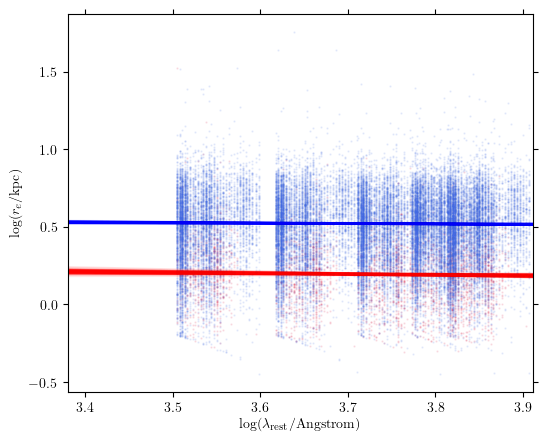

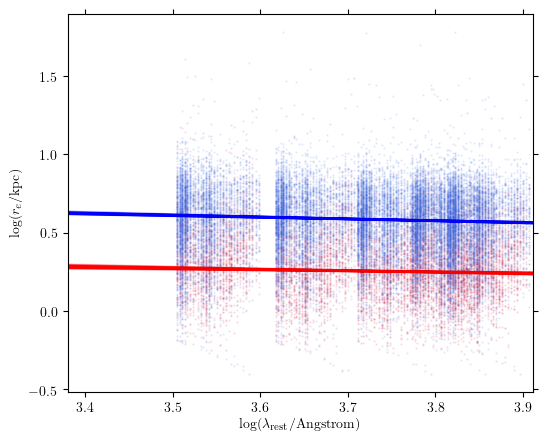

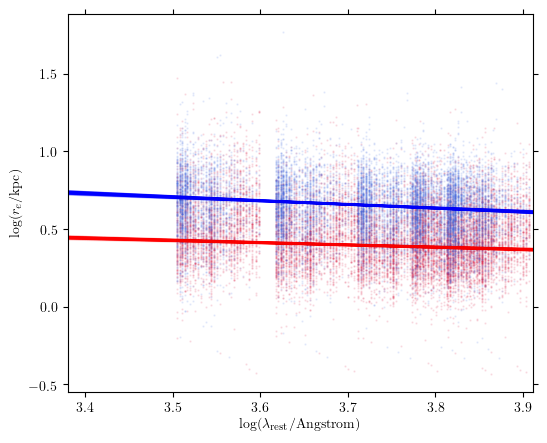

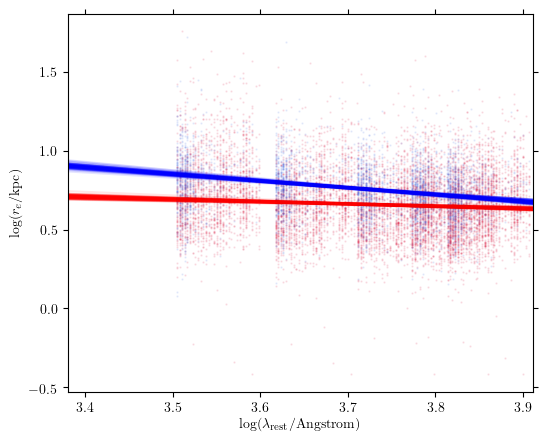

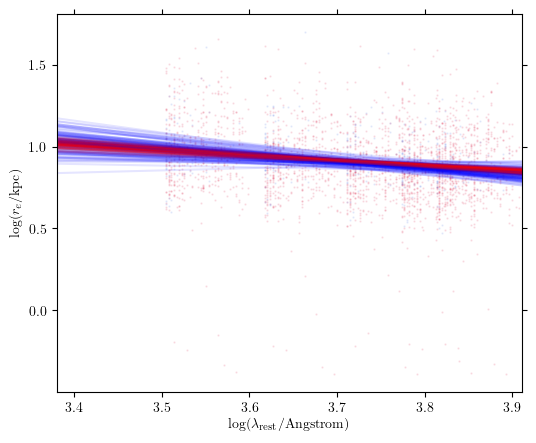

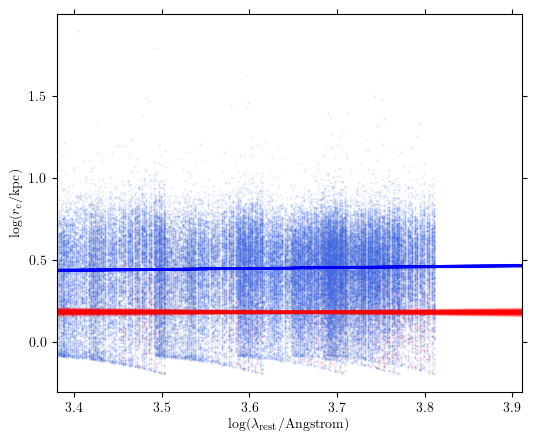

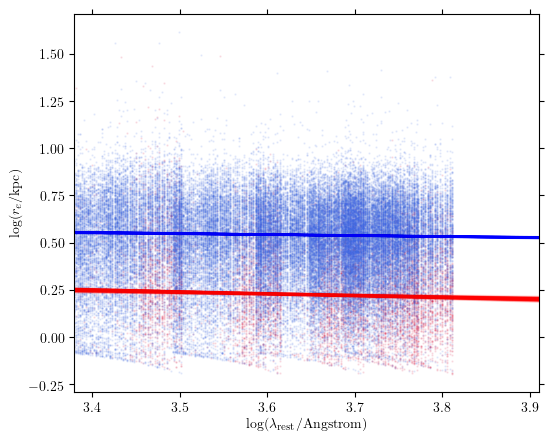

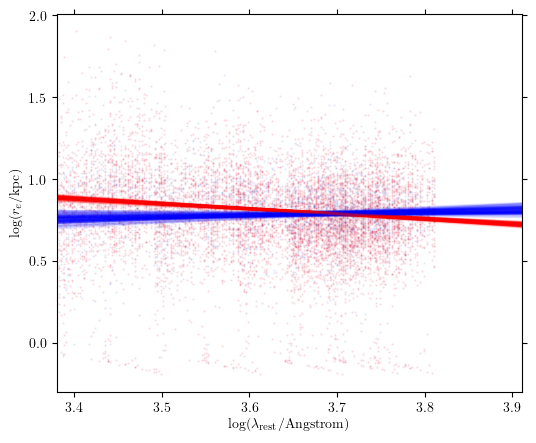

In [7]:
redshiftbins=[0.2,0.5,1.0]
#redshiftbins=[0.2,0.4,0.6,0.8,1.0]


lmassbins = np.hstack([(np.arange(9.5,12,0.4))[:-2] ,12])
for i in range(len(redshiftbins)-1):
    redshiftmin,redshiftmax=redshiftbins[i],redshiftbins[i+1]
    for j in range(len(lmassbins)-1):
        lmassmin,lmassmax=lmassbins[j],lmassbins[j+1]
        tt_sf = (np.where(  (zphot[sf_index] > redshiftmin) &  (zphot[sf_index] <= redshiftmax) & 
                                 (logmstar[sf_index] >lmassmin) & (logmstar[sf_index] <=lmassmax)   ))[0]
        tt_qui = (np.where(  (zphot[qui_index] > redshiftmin) &  (zphot[qui_index] <= redshiftmax) & 
                                 (logmstar[qui_index] >lmassmin) & (logmstar[qui_index] <=lmassmax)   ))[0]
        
        outputfile_name='%sdud/logRe_loglambda_jointfitresult_%.1fz%.1f_%.1flmass%.1f.pkl' % (parent_dir, redshiftmin,redshiftmax,lmassmin,lmassmax)
        fi_glob = glob.glob(outputfile_name)
        
#         _zphot_allwl_qui = zphot_allwl[qui_index,:]
#         print(redshiftmin,redshiftmax,lmassmin,lmassmax)
#         print((_zphot_allwl_qui[tt_qui]).reshape(-1))
#         print('....')
#         print((zphot_allwl[qui_index,:])[tt_qui].reshape(-1))
        if len(fi_glob)==0:
            print(redshiftmin,redshiftmax,lmassmin,lmassmax,len(tt_qui),len(tt_sf))
            sample_dynesty,logZdynesty,logZerrdynesty = fit_logRe_lambda(redshiftmin=redshiftmin,redshiftmax=redshiftmax,
                                                         run_dynesty=True, lmassmin=lmassmin,lmassmax=lmassmax,
                                                         tol=1,SMFweight=True,use_contamfrac=True)

In [6]:

def post_process(redshiftbins=np.array([0.2,0.4,0.6,0.8,1.0]),plot_corner=False,
                 lmassbins = np.hstack([(np.arange(9.5,12,0.4))[:-2] ,12]),
                subdir=None):
    labels=[r'$\alpha_{\mathrm{Q}}$',r'$\log B_{\mathrm{Q}}$', r'$\ln V_{\mathrm{Q}}$',
           r'$\alpha_{z,\mathrm{SF}}$',r'$\log B_{\mathrm{SF}}$', r'$\ln V_{\mathrm{SF}}$']
    
    #redshiftbins=[0.2,0.5,1.0]
    #redshiftbins=[0.2,0.4,0.6,0.8,1.0]
    lmassbinctrs_qui = np.zeros((len(redshiftbins)-1,len(lmassbins)-1))
    lmassbinctrs_sf= np.zeros((len(redshiftbins)-1,len(lmassbins)-1))

    slope_qui_all = np.zeros((len(redshiftbins)-1,len(lmassbins)-1,3))
    slope_sf_all = np.zeros((len(redshiftbins)-1, len(lmassbins)-1,3))

    intercept_qui_all = np.zeros((len(redshiftbins)-1,len(lmassbins)-1,3))
    intercept_sf_all = np.zeros((len(redshiftbins)-1,len(lmassbins)-1,3))

    for j in range(len(redshiftbins)-1):
        redshiftmin,redshiftmax=redshiftbins[j],redshiftbins[j+1]
        for i in range(len(lmassbins)-1):
            lmassmin,lmassmax= lmassbins[i],lmassbins[i+1]
            tt_sf = (np.where(  (zphot[sf_index] > redshiftmin) &  (zphot[sf_index] <= redshiftmax) & 
                                         (logmstar[sf_index] >lmassmin) & (logmstar[sf_index] <=lmassmax)   ))[0]
            tt_qui = (np.where(  (zphot[qui_index] > redshiftmin) &  (zphot[qui_index] <= redshiftmax) & 
                                         (logmstar[qui_index] >lmassmin) & (logmstar[qui_index] <=lmassmax)   ))[0]

            #print(redshiftmin,redshiftmax,lmassmin,lmassmax,len(tt_qui),len(tt_sf))
            lmassbinctrs_qui[j,i] =np.median( (logmstar[qui_index] )[tt_qui])
            lmassbinctrs_sf[j,i] =np.median( (logmstar[sf_index])[tt_sf])
            with open('%sdud/%s/logRe_loglambda_jointfitresult_%.1fz%.1f_%.1flmass%.1f.pkl' % (parent_dir,subdir,redshiftmin,redshiftmax,lmassmin,lmassmax), 'rb') as buff:
                data = pickle.load(buff)
            samples=data['samples_dynesty']
            if plot_corner==True:
                fig_name='%sdud/%s/cornerplots_logRe_loglambda/corner_logRe_loglambda_%.1flmass%.1f_%.1fz%.1f' %  (parent_dir,subdir,lmassmin,lmassmax,redshiftmin,redshiftmax)
                if len(glob.glob(fig_name))==0:
                    plotposts(samples=samples,labels=labels,fig_name=fig_name) 
            slope_qui,intercept_qui,lnV_qui,slope_sf,intercept_sf,lnV_sf = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                     zip(*np.percentile(samples, [16, 50, 84],
                                                        axis=0)))
            slope_qui_all[j,i,0]=slope_qui[0]
            slope_qui_all[j,i,1]=slope_qui[1] # upper error
            slope_qui_all[j,i,2]=slope_qui[2]

            slope_sf_all[j,i,0]=slope_sf[0]
            slope_sf_all[j,i,1]=slope_sf[1]
            slope_sf_all[j,i,2]=slope_sf[2]

            intercept_qui_all[j,i,0]=intercept_qui[0]
            intercept_qui_all[j,i,1]=intercept_qui[1]
            intercept_qui_all[j,i,2]=intercept_qui[2]

            intercept_sf_all[j,i,0]=intercept_sf[0]
            intercept_sf_all[j,i,1]=intercept_sf[1]
            intercept_sf_all[j,i,2]=intercept_sf[2]
    return lmassbinctrs_qui, slope_qui_all,intercept_qui_all, lmassbinctrs_sf,slope_sf_all,intercept_sf_all


def post_process2(redshiftbins=np.array([0.2,0.4,0.6,0.8,1.0]),plot_corner=False,subdir=None):
    labels=[r'$\alpha_{\mathrm{Q}}$',r'$\log B_{\mathrm{Q}}$', r'$\ln V_{\mathrm{Q}}$',
           r'$\alpha_{z,\mathrm{SF}}$',r'$\log B_{\mathrm{SF}}$', r'$\ln V_{\mathrm{SF}}$']
    lmassbins = np.hstack([(np.arange(9.5,12,0.4))[:-2] ,12])
    #redshiftbins=[0.2,0.5,1.0]
    #redshiftbins=[0.2,0.4,0.6,0.8,1.0]
    redshift_qui = np.zeros((len(redshiftbins)-1,len(lmassbins)-1))
    redshift_sf = np.zeros((len(redshiftbins)-1,len(lmassbins)-1))
    lmassbinctrs_qui = np.zeros((len(redshiftbins)-1,len(lmassbins)-1))
    lmassbinctrs_sf= np.zeros((len(redshiftbins)-1,len(lmassbins)-1))

    slope_qui_all = np.zeros((len(redshiftbins)-1,len(lmassbins)-1,2))
    slope_sf_all = np.zeros((len(redshiftbins)-1, len(lmassbins)-1,2))

    intercept_qui_all = np.zeros((len(redshiftbins)-1,len(lmassbins)-1,2))
    intercept_sf_all = np.zeros((len(redshiftbins)-1,len(lmassbins)-1,2))

    for j in range(len(redshiftbins)-1):
        redshiftmin,redshiftmax=redshiftbins[j],redshiftbins[j+1]
        for i in range(len(lmassbins)-1):
            lmassmin,lmassmax= lmassbins[i],lmassbins[i+1]
            tt_sf = (np.where(  (zphot[sf_index] > redshiftmin) &  (zphot[sf_index] <= redshiftmax) & 
                                         (logmstar[sf_index] >lmassmin) & (logmstar[sf_index] <=lmassmax)   ))[0]
            tt_qui = (np.where(  (zphot[qui_index] > redshiftmin) &  (zphot[qui_index] <= redshiftmax) & 
                                         (logmstar[qui_index] >lmassmin) & (logmstar[qui_index] <=lmassmax)   ))[0]

            #print(redshiftmin,redshiftmax,lmassmin,lmassmax,len(tt_qui),len(tt_sf))
            lmassbinctrs_qui[j,i] =np.median(logmstar[qui_index[tt_qui]]  )
            lmassbinctrs_sf[j,i] =np.median(logmstar[sf_index[tt_sf]]  )
            
            redshift_qui[j,i] =np.median(zphot[qui_index[tt_qui]])
            redshift_sf[j,i] =np.median(zphot[sf_index[tt_sf]]    )                           
            with open('%sdud/%s/logRe_loglambda_jointfitresult_%.1fz%.1f_%.1flmass%.1f.pkl' % (parent_dir,subdir, redshiftmin,redshiftmax,lmassmin,lmassmax), 'rb') as buff:
                data = pickle.load(buff)
            samples=data['samples_dynesty']
            if plot_corner==True:
                fig_name='%sdud/%s/cornerplots_logRe_loglambda/corner_logRe_loglambda_%.1flmass%.1f_%.1fz%.1f' %  (parent_dir,subdir,lmassmin,lmassmax,redshiftmin,redshiftmax)
                if len(glob.glob(fig_name))==0:
                    plotposts(samples=samples,labels=labels,fig_name=fig_name) 
            slope_qui,intercept_qui,lnV_qui,slope_sf,intercept_sf,lnV_sf = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                     zip(*np.percentile(samples, [16, 50, 84],
                                                        axis=0)))
            slope_qui_all[j,i,0]=slope_qui[0]
            slope_qui_all[j,i,1]=(slope_qui[1]+slope_qui[2])/2.0 # upper error
            #slope_qui_all[j,i,2]=slope_qui[2]

            slope_sf_all[j,i,0]=slope_sf[0]
            slope_sf_all[j,i,1]=(slope_sf[1]+slope_sf[2])/2.0
            #slope_sf_all[j,i,2]=slope_sf[2]

            intercept_qui_all[j,i,0]=intercept_qui[0]
            intercept_qui_all[j,i,1]=(intercept_qui[1]+intercept_qui[2])/2.0
            #intercept_qui_all[j,i,2]=intercept_qui[2]

            intercept_sf_all[j,i,0]=intercept_sf[0]
            intercept_sf_all[j,i,1]=(intercept_sf[1]+intercept_sf[2])/2.0
            #intercept_sf_all[j,i,2]=intercept_sf[2]
    return lmassbinctrs_qui,redshift_qui, slope_qui_all,intercept_qui_all, lmassbinctrs_sf,redshift_sf,slope_sf_all,intercept_sf_all





(array([[ 9.76128101, 10.13624477, 10.49930191, 10.8560009 , 11.22172737],
        [ 9.78301716, 10.14832497, 10.51768398, 10.89063644, 11.24896622]]),
 array([[[-0.0463155 ,  0.0259431 ,  0.02566602],
         [-0.08219253,  0.01702949,  0.0174048 ],
         [-0.14604892,  0.01542585,  0.01510641],
         [-0.14489824,  0.02536179,  0.02636704],
         [-0.32492033,  0.04942868,  0.04700582]],
 
        [[-0.00523371,  0.03219746,  0.03330133],
         [-0.09211623,  0.01819335,  0.01846578],
         [-0.08362619,  0.01452747,  0.01418858],
         [-0.13265892,  0.01681897,  0.01697275],
         [-0.31060676,  0.02634238,  0.02605354]]]),
 array([[[0.36614992, 0.09493842, 0.09750754],
         [0.56157814, 0.06406652, 0.06400383],
         [0.9375587 , 0.05623721, 0.05782979],
         [1.1988974 , 0.0980205 , 0.09499984],
         [2.11902142, 0.17585186, 0.1843419 ]],
 
        [[0.2009081 , 0.12099405, 0.11827115],
         [0.56092732, 0.06720564, 0.06740147],
         [

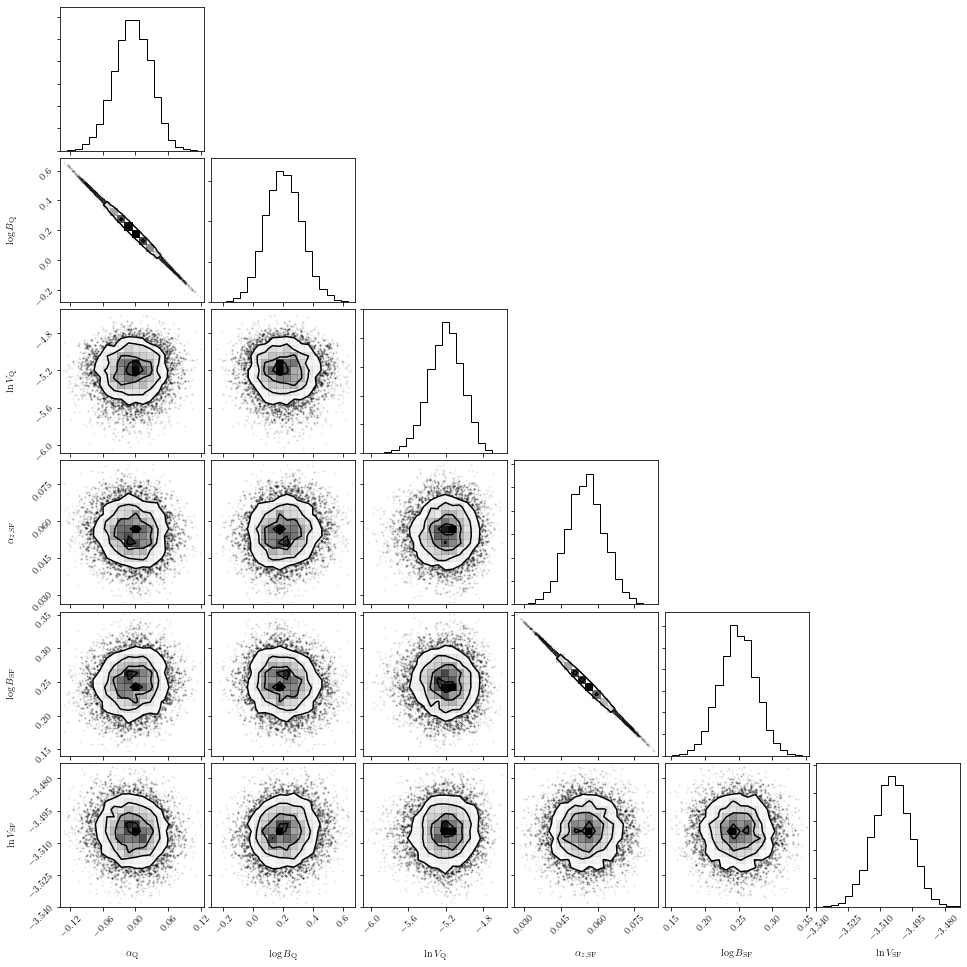

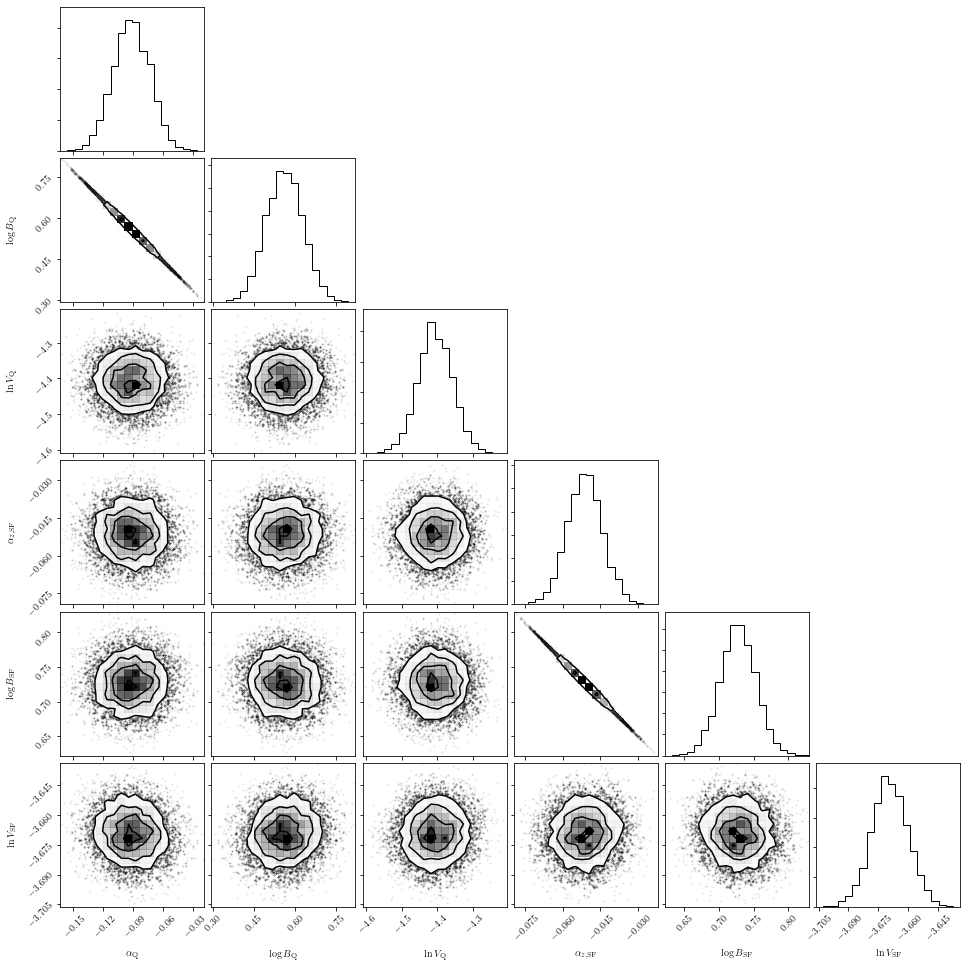

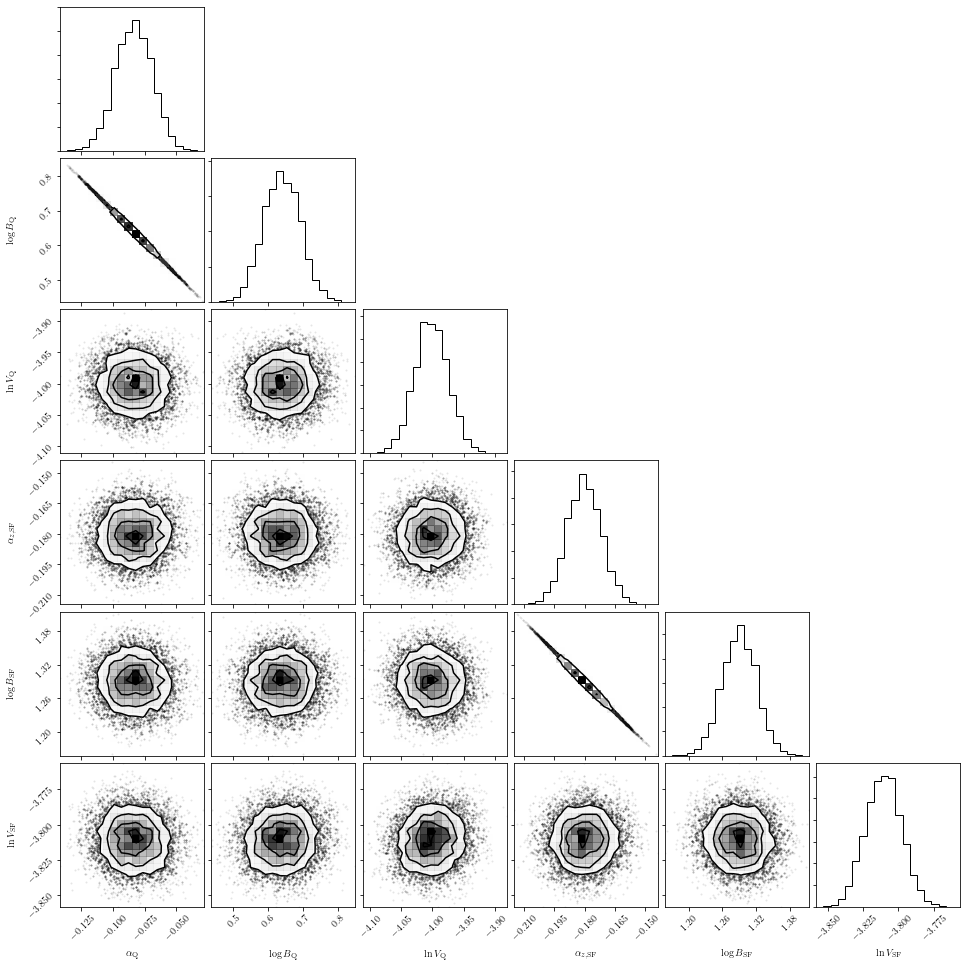

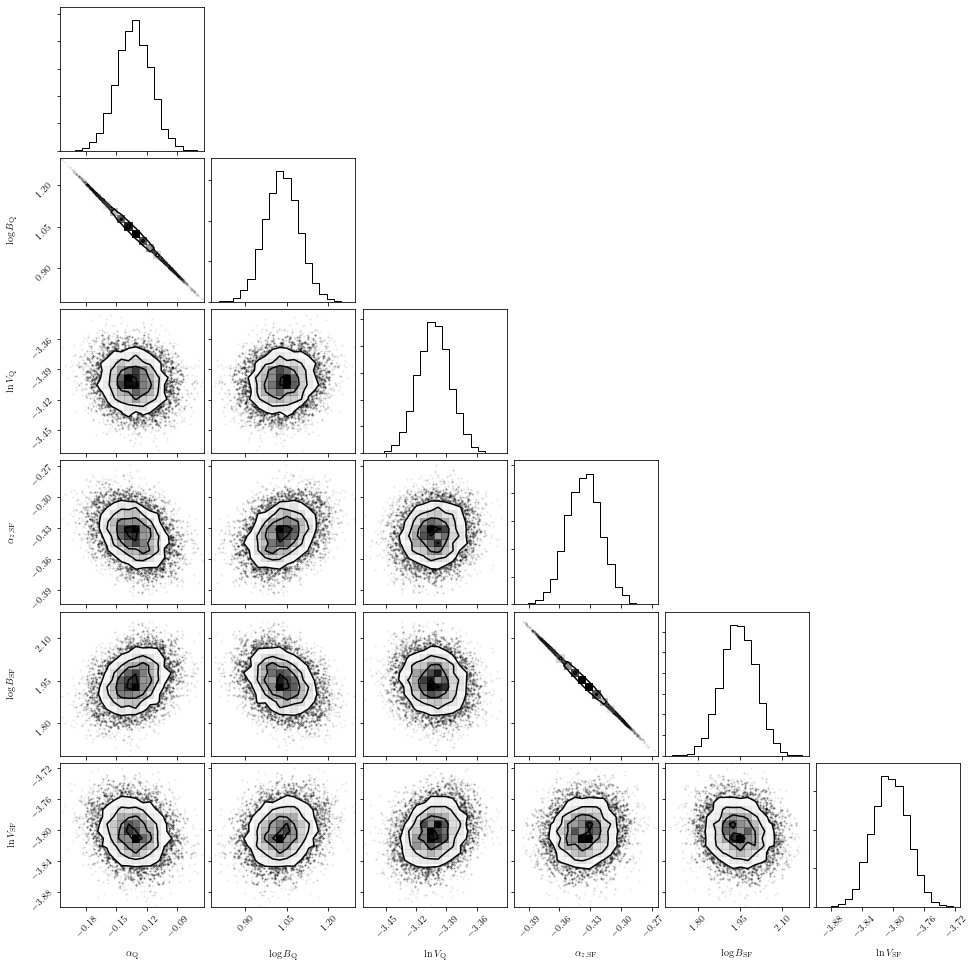

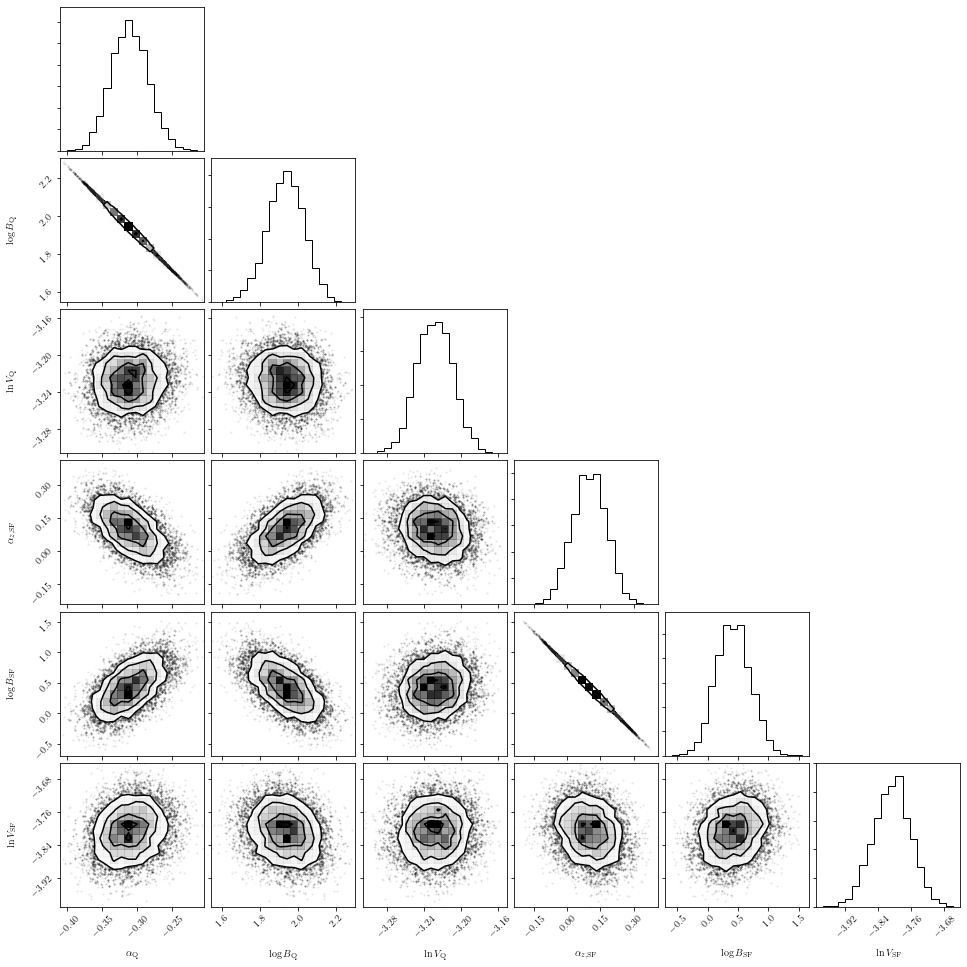

In [11]:
post_process(redshiftbins=np.array([0.2,0.5,1.0]),plot_corner=True,
                #subdir='logRe_loglambda_before_syserr_catastrophic')
                #subdir='logRe_loglambda_syserr_nocatastrophic')
                 subdir='logRe_loglambda_syserr_catastrophic')

In [12]:
def plot_re_lambda(subdir=None,plot_log=False,redshiftbins = np.array([0.2,0.4,0.6,0.8,1.0]) ):# np.array([0.2,0.5,1.0])
    lmassbinctrs_qui, slope_qui_all,intercept_qui_all, lmassbinctrs_sf,slope_sf_all,intercept_sf_all= post_process(redshiftbins=redshiftbins,plot_corner=False,subdir=subdir)
    if (len(redshiftbins)-1 ==4):
        fig,axs= plt.subplots(2,4,figsize=(18,8),dpi=150)
    if (len(redshiftbins)-1 ==2):
        fig,axs= plt.subplots(2,2,figsize=(10,8),dpi=150)
    #axs=axs.ravel()
    meansymsize=7
    lmassbins = np.hstack([(np.arange(9.5,12,0.4))[:-2] ,12])
    #color_reds= ['#d4b9da','#c994c7','#df65b0','#dd1c77','#980043']
    #color_blues=['#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
    
    color_reds=['#fcbba1','#fc9272','#fb6a4a','#de2d26','#a50f15']
    color_blues=['#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
    cmap= mpl.cm.get_cmap('nipy_spectral')
    min_x,max_x=np.log10(np.min(rest_lambda_all)), np.log10(np.max(rest_lambda_all))
    min_y,max_y= -0.5,2
    #x_arr = np.arange(np.log10(2000), np.log10(30000),0.1) #np.linspace(min_x,max_x,100 )
    linestyles=['-','--','-.',':','-']
    ypos=0.01
    xpos=0.05
    for j in range(len(redshiftbins)-1):
    #for j in [0]:
        redshiftmin,redshiftmax=redshiftbins[j],redshiftbins[j+1]
        zmed =np.median([redshiftmin,redshiftmax]) 
        median_fwhm_allwl = np.median(fwhm_allwl,axis=0)
        half_fwhm= (median_fwhm_allwl/2)* (cosmo.kpc_proper_per_arcmin(zmed).to(u.kpc/u.arcsec)).value
        hscbands_restwl=(np.array([g_lambda,r_lambda,i_lambda,z_lambda,y_lambda])/10.0)/(1+zmed)
        hscbands_restwl_angstr=np.array([g_lambda,r_lambda,i_lambda,z_lambda,y_lambda])/(1+zmed)
        x_arr = np.linspace(np.log10( np.min(hscbands_restwl_angstr)), np.log10( np.max(hscbands_restwl_angstr)),100)
        #print(zmed,half_fwhm,hscbands_restwl)
        min_r_fit = 0.01*(cosmo.kpc_proper_per_arcmin(zmed).to(u.kpc/u.arcsec)).value
        axs[0,j].set_title(r'$%.1f < z < %.1f$' % (redshiftmin,redshiftmax),fontsize=myfontsize-2)
        for k in [0,1]:
            #axs[k,j].plot(hscbands_restwl, half_fwhm,color='grey',ls='--',lw=2)
            axs[k,j].fill_between(hscbands_restwl,min_r_fit,half_fwhm,alpha=0.5,color='lightgrey')
            #axs[k,j].axhspan(ymin=min_r_fit,ymax=half_fwhm,alpha=0.5,color='grey')
            #axs[k,j].axhline(y=half_fwhm,color='grey',ls='--',lw=2)       
            #print(zmed, half_fwhm)
            if (k==0): # label wavelegth
                for m,w,c, in zip(hscbands_restwl,['g','r','i','z','y'],[0.1,0.2,0.4,0.6,0.9]):
                    axs[k,j].text(m,17,r'$\textbf{%s}$' % w ,fontsize=myfontsize-3,color=cmap(c)) #
        for i in range(len(lmassbins)-1):
        #for i in [0]:
            lmassmin,lmassmax= lmassbins[i],lmassbins[i+1]
            lmass_med=np.median([lmassmin,lmassmax])
            #plot_kwargs_qui={'ls':linestyles[0],'color':color_reds[i],'lw':i+1}
            #plot_kwargs_sf={'ls':linestyles[0],'color':color_blues[i],'lw':i+1}
            plot_kwargs_qui={'ls':linestyles[i],'color':'crimson','lw':i+1}
            plot_kwargs_sf={'ls':linestyles[i],'color':'royalblue','lw':i+1}
            
            
            if (plot_log==True):
                axs[0,j].plot(x_arr,func_logre_loglambda(x_arr,slope_qui_all[j,i,0],intercept_qui_all[j,i,0]), **plot_kwargs_qui)
                axs[1,j].plot(x_arr,func_logre_loglambda(x_arr,slope_sf_all[j,i,0],intercept_sf_all[j,i,0]), **plot_kwargs_sf)
            if (plot_log==False):
                if (lmassmin> (data_mcomp_deep['mlim_func_qui'])(redshiftmax) ):
                    axs[0,j].plot( (10**x_arr)/10.0,10**func_logre_loglambda(x_arr,slope_qui_all[j,i,0],intercept_qui_all[j,i,0]), **plot_kwargs_qui)
                if (lmassmin> (data_mcomp_deep['mlim_func_sf'])(redshiftmax) ):
                    axs[1,j].plot((10**x_arr)/10.0,10**func_logre_loglambda(x_arr,slope_sf_all[j,i,0],intercept_sf_all[j,i,0]), 
                              **plot_kwargs_sf,label=r'$10^{%.1f}~M_{\odot}$' % lmass_med)
            #print(i,lmassmin,lmassmax)
            
            #print(10**func_logre_loglambda(x_arr,slope_qui_all[j,i,0],intercept_qui_all[j,i,0])) 
            #print(10**func_logre_loglambda(x_arr,slope_sf_all[j,i,0],intercept_sf_all[j,i,0])) 
            #if (j==0):
                
                #axs[1,j].text(xpos,ypos,r'$M_{\ast}=10^{%.1f-%.1f}~M_{\odot}$' % (lmassmin,lmassmax),
                #              fontsize=myfontsize-6,color=color_blues[i],transform=axs[1,j].transAxes)
                #ypos=ypos+0.08
    if (plot_log==True):
        axs[0,0].set_ylabel(r'$\log (R_{e}/\mathrm{kpc})$')
        axs[1,0].set_ylabel(r'$\log (R_{e}/\mathrm{kpc})$')
    if (plot_log==False):
        axs[0,0].set_ylabel(r'$R_{e}/\mathrm{kpc}$')
        axs[1,0].set_ylabel(r'$R_{e}/\mathrm{kpc}$')
    for i in range(len(redshiftbins)-1):
        if (plot_log==True):
            axs[1,i].set_xlabel(r'$\log (\lambda_{\mathrm{rest}}/$Angstrom)')
        if (plot_log==False):
            axs[1,i].set_xlabel(r'$\lambda_{\mathrm{rest}}/$nm')
            
        for k in [0,1]:
            if (plot_log==True):
                axs[k,i].set_xlim(min_x,max_x)
            if (plot_log==False):
                axs[k,i].set_yscale('log')
                axs[k,i].set_xscale('log')
                axs[k,i].yaxis.set_major_formatter(ScalarFormatter())
                axs[k,i].yaxis.set_minor_locator(NullLocator())
                axs[k,i].set_yticks([2, 3, 5, 7,10,15])
                axs[k,i].set_ylim(1,20)
                
                axs[k,i].xaxis.set_major_formatter(ScalarFormatter())
                axs[k,i].xaxis.set_minor_locator(NullLocator())
                #axs[k,i].set_xticks([300, 500,1000,2000])
                #axs[k,i].set_xlim(200,2800)
                axs[k,i].set_xticks([250,300,400,500,600,700])
                axs[k,i].set_xlim(240,800 )
                
            #ax.set_ylim(min_y,max_y)
            axs[k,i].yaxis.set_ticks_position('both')
            axs[k,i].xaxis.set_ticks_position('both')
            if (i>0):
                axs[k,i].set_yticks([])
        axs[0,i].set_xticks([])
    axs[0,0].text(370,1,r'$R_{e}<0.5\times\mathrm{FWHM}$',fontsize=myfontsize-5,
                  path_effects=[path_effects.Stroke(linewidth=3, foreground='w'),path_effects.Normal()])
    # plot low-z result from Kelvin+12
    #if (plot_log==True):
      
    #    axs[0,0].plot(x_arr,func_logre_loglambda(x_arr,-0.304,1.506),color='r',ls=':')
    #    axs[1,0].plot(x_arr,func_logre_loglambda(x_arr,-0.189,1.176),color='b',ls=':')
    axs[0,0].text(0.05,0.9,'Quiescent',transform=axs[0,0].transAxes,fontsize=myfontsize-2)
    axs[1,0].text(0.05,0.9,'Star-forming',transform=axs[1,0].transAxes,fontsize=myfontsize-2)
    #axs[1,0].legend(loc='upper center',fontsize=myfontsize-3,labelspacing=0.1,bbox_to_anchor=(0.5, -0.05),ncol=5)
    leg_this_work=axs[1,0].legend(loc=3,fontsize=myfontsize-6,labelspacing=0.1,borderpad=0.1,ncol=2,
                                  handlelength=2,columnspacing=1)
    if (plot_log==False):
        # for Kelvin+12
        x_arr = np.linspace(np.log10( 3000), np.log10( 20000),100)
        axs[0,0].plot((10**x_arr)/10.0,10**func_logre_loglambda( np.log10((10**x_arr)/10.0),-0.304,1.506),
                      color='magenta',ls=':',lw=1.5)
        axs[1,0].plot((10**x_arr)/10.0,10**func_logre_loglambda(np.log10((10**x_arr)/10.0),-0.189,1.176),
                      color='cyan',ls=':',lw=1.5)
    
    legend_elements = [Line2D([0], [0], color='cyan', ls=':',lw=1.5, label=r'$z<0.25$'+'\n'+'(Kelvin+12)')]
    
    axs[1,0].legend(handles=legend_elements, loc=1,fontsize=myfontsize-6,borderpad=0.1,handlelength=1.8,
                    bbox_to_anchor=(1.05, 1))
    axs[1,0].add_artist(leg_this_work)
    fig.subplots_adjust(left=0.1,hspace=0.0, wspace=0.00,top=0.95,bottom=0.08,right=0.95)
    if (len(redshiftbins)-1 ==2):
        fig.savefig('%sdud/%s/Re_lambda_tworedshiftbins.png' % (parent_dir,subdir))
    if (len(redshiftbins)-1 ==4):
        fig.savefig('%sdud/%s/Re_lambda_fourredshiftbins.png' % (parent_dir,subdir))
    

In [15]:
plot_re_lambda(plot_log=False,redshiftbins = np.array([0.2,0.5,1.0]), 
               #subdir='logRe_loglambda_before_syserr_catastrophic')
               #subdir='logRe_loglambda_syserr_nocatastrophic')
               subdir='logRe_loglambda_syserr_catastrophic')

In [27]:
#def func_logre_logmass2(X,a,b,c):
def func_logre_logmass2(X,a,b,c,d):
    z,logm = X
    return a+b*np.power(z,2)+c*z+d*(logm)
    #return a+b*z+c*(logm-10)
def fit_colorgrad_mass2(redshiftbins=None,lmassbins=None,color_gradient_slope=None):#,ax=None,plot_kwargs=None):
    redshiftbinctrs=redshiftbins[:-1]+(redshiftbins[1:]-redshiftbins[:-1])/2.0
    lmassbinctrs =lmassbins[:-1]+(lmassbins[1:]-lmassbins[:-1])/2.0
    X = np.zeros( (  (len(redshiftbins)-1)* (len(lmassbins)-1),2) )
    Y=np.zeros((len(redshiftbins)-1)* (len(lmassbins)-1))
    sample_weight = np.zeros((len(redshiftbins)-1)* (len(lmassbins)-1))
    k=0
    for i in range(len(redshiftbinctrs)):
        for j in range(len(lmassbinctrs)):
            X[k,0]=redshiftbinctrs[i]
            X[k,1]=lmassbinctrs[j] -10   # normalize M by 10^10
            Y[k] = color_gradient_slope[i,j,0]
            yerr= ((color_gradient_slope[i,j,1])+ (color_gradient_slope[i,j,2]))/2.0
            sample_weight[k]= 1/(yerr**2)
            k=k+1
    regressor = LinearRegression(normalize=True)
    regressor.fit(X, Y,sample_weight)
    score=regressor.score(X, Y,sample_weight)
    #return X,Y,sample_weight
    return regressor.intercept_, regressor.coef_[0],regressor.coef_[1],score



def plot_colorgrad_v2(redshiftbins = np.array([0.2,0.4,0.6,0.8,1.0]),
                      plot_log=False,use_masscomplete=True,fit_option=1, apply_mask=True,subdir=None):
    lmassbinctrs_qui, slope_qui_all,intercept_qui_all, lmassbinctrs_sf,slope_sf_all,intercept_sf_all= post_process(redshiftbins=redshiftbins,plot_corner=False,subdir=subdir)
    #_lmassbinctrs_qui,_redshift_qui, _slope_qui_all,_intercept_qui_all, _lmassbinctrs_sf,_redshift_sf,_slope_sf_all,_intercept_sf_all=post_process2(redshiftbins=np.array([0.2,0.5,1.0]),plot_corner=False)


    fig,axs= plt.subplots(2,1,figsize=(5.5,9),dpi=150)
    axs=axs.ravel()
    meansymsize=10
    lmassbins = np.hstack([(np.arange(9.5,12,0.4))[:-2] ,12])
    lmassbinctrs =lmassbins[:-1]+(lmassbins[1:]-lmassbins[:-1])/2.0
    color_reds=['#fcae91','#fb6a4a','#de2d26','#a50f15']
    color_blues=['#bdd7e7','#6baed6','#3182bd','#08519c']
    if len(redshiftbins)==3:
        color_reds=['crimson','lightcoral']
        color_blues = ['royalblue','lightskyblue']
    lmass_arr= np.arange(9.5,12,0.1)
    xpos=0.02
    ypos=0.02
    #redshiftbins=np.array([0.2,0.4,0.6,0.8,1.0])
    redshiftbinctrs=redshiftbins[:-1]+(redshiftbins[1:]-redshiftbins[:-1])/2.0
    # assign flag to quiescent galaxies fitting result (1=good, 0=bad), 0 means that R<0.5 FWHM

    goodflag_qui= np.ones_like(slope_qui_all)
    goodflag_sf= np.ones_like(slope_sf_all)
    if (apply_mask==True) :
        goodflag_qui[0,0,:]=0 # 0.2<z<0.4
        goodflag_qui[0,1,:]=0 # 0.2<z<0.4
        goodflag_qui[1,0,:]=0# 0.4<z<0.6
        goodflag_qui[1,1,:]=0
        goodflag_qui[1,2,:]=0
        
        #goodflag_sf[0,-1,:]=0
        goodflag_sf[1,0,:]=0
        #goodflag_sf[1,-1,:]=0
        goodflag_sf[0,0,:]=0
#         if ((np.shape(slope_qui_all))[0])==4:
#             #goodflag_qui[1,1,:]=0
#             goodflag_qui[2,0,:]=0 # 0.6<z<0.8
#             #goodflag_qui[2,1,:]=0
#             #goodflag_qui[2,2,:]=0
#             goodflag_qui[3,0,:]=0 #0.8<z<1.0
#             goodflag_qui[3,1,:]=0
#             #goodflag_qui[3,2,:]=0
    if (fit_option==3):
        x=_redshift_sf[:,1:].reshape(-1)
        y=_lmassbinctrs_sf[:,1:].reshape(-1)
        z=_slope_sf_all[:,1:,0].reshape(-1)
        z_err=_slope_sf_all[:,1:,1].reshape(-1)
        #print(np.shape(x),np.shape(z),np.shape(y),np.shape(z_err))
        popt_sf,pcov_sf=curve_fit(func_logre_logmass2, (x,y), z,sigma=z)
        # nonlinear in z
        zbins=[0.3,0.8]#[0.3,0.5,0.7,0.9]
        for i in range(len(zbins)):
            fit_result_sf_new=func_logre_logmass2( (np.ones(len(lmass_arr))*zbins[i], lmass_arr),*popt_sf)
            axs[1].plot(10**lmass_arr ,fit_result_sf_new,color=color_blues[i] ,ls='-',lw=3)

    if (fit_option==2):
        # assign very low weight to the lowest-mass bin at z=0.9
        slope_qui_all_copy = copy.deepcopy(slope_qui_all)
        slope_sf_all_copy = copy.deepcopy(slope_sf_all)
        if (apply_mask==True):
            slope_qui_all_copy[0,0,1:]=1e+6
            slope_qui_all_copy[0,1,1:]=1e+6
            slope_qui_all_copy[1,0,1:]=1e+6
            slope_qui_all_copy[1,1,1:]=1e+6
            slope_qui_all_copy[1,2,1:]=1e+6
            
            #slope_sf_all_copy[0,-1,1:]=1e+6
            #slope_sf_all_copy[1,-1,1:]=1e+6
            slope_sf_all_copy[0,0,1:]=1e+6
            slope_sf_all_copy[1,0,1:]=1e+6
            if ((np.shape(slope_qui_all))[0])==4:
                slope_qui_all_copy[1,1,1:]=1e+6
                #slope_qui_all_copy[2,0,1:]=1e+6
                slope_qui_all_copy[2,1,1:]=1e+6
                slope_qui_all_copy[2,2,1:]=1e+6

                slope_qui_all_copy[3,0,1:]=1e+6
                slope_qui_all_copy[3,1,1:]=1e+6
                #slope_qui_all_copy[3,2,1:]=1e+6
        intercept_qui_linmod, slope_z_qui_linmod,slope_mass_qui_linmod,score_qui =fit_colorgrad_mass(redshiftbins=np.array(redshiftbins),
                                                              lmassbins=np.hstack([(np.arange(9.5,12,0.4))[:-2] ,12])
                                                              ,color_gradient_slope=slope_qui_all_copy)
        intercept_sf_linmod, slope_z_sf_linmod,slope_mass_sf_linmod,score_sf =fit_colorgrad_mass(redshiftbins=np.array(redshiftbins),
                                                              lmassbins=np.hstack([(np.arange(9.5,12,0.4))[:-2] ,12])
                                                              ,color_gradient_slope=slope_sf_all_copy)
        print('qui:',intercept_qui_linmod, slope_z_qui_linmod,slope_mass_qui_linmod,score_qui)
        print('sf:',intercept_sf_linmod, slope_z_sf_linmod,slope_mass_sf_linmod,score_sf)
    for j in range(len(redshiftbins)-1):
    #for j in [0]:
        redshiftmin,redshiftmax=redshiftbins[j],redshiftbins[j+1]
        #this_label= r'$%.1f<z<%.1f$' % (redshiftmin,redshiftmax)
        this_label=r'$z=%.1f$' % np.mean([redshiftmin,redshiftmax])
        zmean=np.mean([redshiftmin,redshiftmax])
        mlim_qui=10
        mlim_sf = 10#(data_mcomp_deep['mlim_func_sf'])(redshiftmax)
        if (apply_mask==True):
            tcomp_qui = (np.where( (lmassbinctrs> mlim_qui) &
                                  (goodflag_qui[j,:,0] >0  ) ))[0]

            tcomp_qui_notuse = (np.where( (goodflag_qui[j,:,0] ==0  ) ))[0]
            
            tcomp_sf = (np.where( (lmassbinctrs> mlim_sf) &
                                  (goodflag_sf[j,:,0] >0  ) ))[0]
            tcomp_sf_notuse = (np.where( (goodflag_sf[j,:,0] ==0  ) ))[0]
            
        if (apply_mask==False):
            tcomp_qui = (np.where(lmassbinctrs> (data_mcomp_deep['mlim_func_qui'])(redshiftmax)))[0]
            tcomp_sf = (np.where(lmassbinctrs> (data_mcomp_deep['mlim_func_sf'])(redshiftmax)))[0]
            print( (data_mcomp_deep['mlim_func_qui'])(redshiftmax),(data_mcomp_deep['mlim_func_sf'])(redshiftmax))
        #print('np.shape(lmassbinctrs)',np.shape(lmassbinctrs))
#         popt_qui, pcov_qui= curve_fit(func_logre_logmass2,
#                                       (np.ones(len(tcomp_qui))*zmean,lmassbinctrs_qui[j,tcomp_qui]),
#                                       slope_qui_all[j,tcomp_qui,0],
#                                       sigma=(slope_qui_all[0,tcomp_qui,1]+slope_qui_all[0,tcomp_qui,2])

#         popt_qui, pcov_qui= curve_fit(func_logre_logmass,lmassbinctrs_qui[j,tcomp_qui],
#                                      slope_qui_all[j,tcomp_qui,0]#,bounds=([-1,0], [1,2]) 
#                              ,sigma=(slope_qui_all[0,tcomp_qui,1]+slope_qui_all[0,tcomp_qui,2])/2.0)
#         popt_sf, pcov_sf= curve_fit(func_logre_logmass,lmassbinctrs_sf[j,tcomp_sf],
#                                      slope_sf_all[j,tcomp_sf,0]#,bounds=([-1,0], [1,2]) 
#                              ,sigma=(slope_sf_all[0,tcomp_sf,1]+slope_sf_all[0,tcomp_sf,2])/2.0)
#        print(redshiftmin,redshiftmax,'popt_sf',popt_sf)
        plot_kwargs_qui={'fmt':'-o','color':'none','mec':color_reds[j], 'mfc':color_reds[j],'ecolor':color_reds[j],
                             'markersize':meansymsize,'capthick':1,'capsize':5,'alpha':1,'mew':2}
    
        plot_kwargs_qui_open={'fmt':'o','color':'none','mec':color_reds[j], 'mfc':'w','ecolor':color_reds[j],
                             'markersize':meansymsize,'capthick':1,'capsize':5,'alpha':1,'mew':1}
        
        
        plot_kwargs_sf={'fmt':'-s','color':'none','mec':color_blues[j], 'mfc':color_blues[j],'ecolor':color_blues[j],
                             'markersize':meansymsize,'capthick':1,'capsize':5,'alpha':1,'mew':2}
        
        plot_kwargs_sf_open={'fmt':'s','color':'none','mec':color_blues[j], 'mfc':'w','ecolor':color_blues[j],
                             'markersize':meansymsize,'capthick':1,'capsize':5,'alpha':1,'mew':1}
        
        if (use_masscomplete==False):
            err_qui =(np.dstack([slope_qui_all[j,:,2],slope_qui_all[j,:,1]]))[0]
            err_sf =(np.dstack([slope_sf_all[j,:,2],slope_sf_all[j,:,1]]))[0]
        
        if (use_masscomplete==True):
            err_qui =(np.dstack([slope_qui_all[j,tcomp_qui,2],slope_qui_all[j,tcomp_qui,1]]))[0]
            err_sf =(np.dstack([slope_sf_all[j,tcomp_sf,2],slope_sf_all[j,tcomp_sf,1]]))[0]
            if (apply_mask==True):
                err_qui_notuse =(np.dstack([slope_qui_all[j,tcomp_qui_notuse,2],slope_qui_all[j,tcomp_qui_notuse,1]]))[0]
                err_sf_notuse =(np.dstack([slope_sf_all[j,tcomp_sf_notuse,2],slope_sf_all[j,tcomp_sf_notuse,1]]))[0]
        if (plot_log==True):
            if (use_masscomplete==False):
                axs[0].errorbar(lmassbinctrs_qui[j,:],slope_qui_all[j,:,0],
                                yerr=err_qui.T,**plot_kwargs_qui,label=this_label)
                axs[1].errorbar(lmassbinctrs_sf[j,:],slope_sf_all[j,:,0],yerr=err_sf.T,**plot_kwargs_sf,label=this_label)
            if (use_masscomplete==True):
                axs[0].errorbar(lmassbinctrs_qui[j,tcomp_qui],slope_qui_all[j,tcomp_qui,0],
                                yerr=err_qui.T,**plot_kwargs_qui,label=r'$%.1f<z<%.1f$' % (redshiftmin,redshiftmax))
                axs[1].errorbar(lmassbinctrs_sf[j,tcomp_sf],slope_sf_all[j,tcomp_sf,0],yerr=err_sf.T,**plot_kwargs_sf,label=this_label)
            axs[1].plot(lmass_arr,color_grad_vdw,color=color_blues[j],ls=':')
        if (plot_log==False):
            if (use_masscomplete==False):
                axs[0].errorbar(10**lmassbinctrs_qui[j,:],slope_qui_all[j,:,0],yerr=err_qui.T,**plot_kwargs_qui,label=this_label)
                axs[1].errorbar(10**lmassbinctrs_sf[j,:],slope_sf_all[j,:,0],yerr=err_sf.T,**plot_kwargs_sf,label=this_label)
            if (use_masscomplete==True):
                
                axs[0].errorbar(10**lmassbinctrs_qui[j,tcomp_qui],slope_qui_all[j,tcomp_qui,0],yerr=err_qui.T,**plot_kwargs_qui,label=this_label)
                # let take the average values of color gradient for quiescent galaxies
                #axs[0].axhline(y=np.median(slope_qui_all[j,tcomp_qui,0]),color=plot_kwargs_qui['color'],lw=3)
                axs[1].errorbar(10**lmassbinctrs_sf[j,tcomp_sf],slope_sf_all[j,tcomp_sf,0],yerr=err_sf.T,**plot_kwargs_sf,label=this_label)
                if (apply_mask==True):
                    axs[0].errorbar(10**lmassbinctrs_qui[j,tcomp_qui_notuse],slope_qui_all[j,tcomp_qui_notuse,0],
                                yerr=err_qui_notuse.T,**plot_kwargs_qui_open)
                    axs[1].errorbar(10**lmassbinctrs_sf[j,tcomp_sf_notuse],slope_sf_all[j,tcomp_sf_notuse,0],
                                yerr=err_sf_notuse.T,**plot_kwargs_sf_open)
                if (fit_option==1):
                    #show fit result for each redshift bins (using curvefit)
                    axs[0].plot(10**lmass_arr,func_logre_logmass(lmass_arr,*popt_qui),color=color_reds[j],ls='--',lw=2)
                    axs[1].plot(10**lmass_arr,func_logre_logmass(lmass_arr,*popt_sf),color=color_blues[j],ls='--',lw=2)
                    # label fitted params
                    axs[0].text(xpos,ypos,r'$%.2f %.2f\log(M_{\ast}/10^{10}M_{\odot})$' % (popt_qui[1],popt_qui[0]),
                                fontsize=myfontsize-2,color=color_reds[j],transform=axs[0].transAxes)

                    axs[1].text(xpos,ypos,r'$%.2f %.2f\log(M_{\ast}/10^{10}M_{\odot})$' % (popt_sf[1],popt_sf[0]),
                                fontsize=myfontsize-2,color=color_blues[j],transform=axs[1].transAxes)
                    ypos=ypos+0.08
                if (fit_option==2):
                    # show result from linear model 
                    fit_result_qui=intercept_qui_linmod+ slope_z_qui_linmod*redshiftbinctrs[j]+slope_mass_qui_linmod *(lmass_arr-10)
                    axs[0].plot(10**lmass_arr ,fit_result_qui,color=color_reds[j] ,ls='-.',lw=3)
                      
                    fit_result_sf=intercept_sf_linmod+ slope_z_sf_linmod*redshiftbinctrs[j]+slope_mass_sf_linmod *(lmass_arr-10)
                    axs[1].plot(10**lmass_arr ,fit_result_sf,color=color_blues[j] ,ls='-.',lw=3)
                    
                    
                                 
                    if (slope_z_qui_linmod<0):
                        eq_qui=r'$%.2f %.2f z %.2f\log(M_{\ast}/10^{10}M_{\odot})$' % (intercept_qui_linmod,slope_z_qui_linmod,slope_mass_qui_linmod)
                    if (slope_z_qui_linmod>0):
                        eq_qui=r'$%.2f+%.2f z %.2f\log(M_{\ast}/10^{10}M_{\odot})$' % (intercept_qui_linmod,slope_z_qui_linmod,slope_mass_qui_linmod)
                    if (round(slope_z_qui_linmod,2)==0):
                        eq_qui=r'$%.2f %.2f\log(M_{\ast}/10^{10}M_{\odot})$' % (intercept_qui_linmod,slope_mass_qui_linmod)
                    axs[0].text(xpos,ypos,eq_qui,
                                fontsize=myfontsize-2,color=color_reds[0],transform=axs[0].transAxes)
                    if (slope_z_sf_linmod<0):
                        eq_sf =r'$%.2f %.2f z %.2f\log(M_{\ast}/10^{10}M_{\odot})$' % (intercept_sf_linmod,slope_z_sf_linmod,slope_mass_sf_linmod)
                    if (slope_z_sf_linmod > 0):
                        eq_sf =r'$%.2f + %.2f z %.2f\log(M_{\ast}/10^{10}M_{\odot})$' % (intercept_sf_linmod,slope_z_sf_linmod,slope_mass_sf_linmod)
                    axs[1].text(xpos,ypos,eq_sf,
                                fontsize=myfontsize-2,color=color_blues[0],transform=axs[1].transAxes)
            # for SF
            color_grad_vdw = -0.35+0.12*np.mean([redshiftmin,redshiftmax]) -0.25*(lmass_arr-10.0)  
            color_grad_angelo=1.2+0.14*(np.mean([redshiftmin,redshiftmax])**2)-0.05*np.mean([redshiftmin,redshiftmax]) -0.135*(lmass_arr)
            axs[1].plot(10**lmass_arr,color_grad_vdw,color=color_blues[j],ls=':')
            axs[1].plot(10**lmass_arr,color_grad_angelo,color=color_blues[j],ls='--')
        #print(lmassmin,lmassmax,slope_qui[0],slope_sf[0])
    for i in range(len(axs)):
        if (plot_log==False):
            axs[i].set_xscale('log')
            #axs[i].set_xlim(10**(9.5),5e+11)
            axs[i].set_xlim(10**(9.5),1e+11)
        if (plot_log==True):
            axs[i].set_xlim(9.5,12)    
        axs[i].set_ylim(-0.65,0.1)
        if (plot_log==True):
            axs[i].set_xlabel(r'$\log M_{\ast}/M_{\odot}$')
        if (plot_log==False):
            axs[i].set_xlabel(r'$M_{\ast}/M_{\odot}$')
        axs[i].set_ylabel(r'$\Delta \log (r_{e})/ \Delta \log (\lambda)$')
        axs[i].yaxis.set_ticks_position('both')
        axs[i].xaxis.set_ticks_position('both')
        axs[i].tick_params(axis='both', direction='in',which='both')
        axs[i].tick_params(axis='both',which='major',length=7)
        axs[i].tick_params(axis='both',which='minor',length=3)
        
        axs[i].yaxis.set_major_locator( MultipleLocator(0.1))
        axs[i].yaxis.set_minor_locator( MultipleLocator(0.05))
        
    axs[0].axhline(y=-0.25,color='r',ls=':') # vdW+14 correction for Qui
    #axs[0].axhline(y=-0.21,color='r',ls='--') # Angelo correction for Qui
    leg_this_work_qui =axs[0].legend(loc=1,fontsize=myfontsize-6,ncol=2,borderpad=0.2,handlelength=1.5,labelspacing=0.1,columnspacing=1)
    leg_this_work_sf= axs[1].legend(loc=1,fontsize=myfontsize-6,ncol=2,borderpad=0.2,handlelength=1.5,labelspacing=0.1,columnspacing=1)
    # plot relation from vdW
    legend_elements_vdw_qui = [Line2D([0], [0], color=color_reds[-1], ls=':',lw=1.5, label=r'vdW+14')]
                              #Line2D([0], [0], color=color_reds[-1], ls='--',lw=1.5, label=r'George+in prep.')]
    legend_elements_vdw_sf = [Line2D([0], [0], color=color_blues[-1], ls=':',lw=1.5, label=r'vdW+14')]
                              #Line2D([0], [0], color=color_blues[-1], ls='--',lw=1.5, label=r'George+in prep.')]
    
    axs[0].legend(handles=legend_elements_vdw_qui, loc=1,fontsize=myfontsize-6,borderpad=0.3,handlelength=1.5,bbox_to_anchor=(1, 0.9))
    axs[1].legend(handles=legend_elements_vdw_sf, loc=1,fontsize=myfontsize-6,borderpad=0.3,handlelength=1.5,bbox_to_anchor=(1,0.9))

    axs[0].add_artist(leg_this_work_qui )
    axs[1].add_artist(leg_this_work_sf)
    

    fig.subplots_adjust(left=0.2,hspace=0.0, wspace=0.00,top=0.98,bottom=0.08,right=0.95)
    if (len(redshiftbins)-1 ==4):
        fig.savefig('%sdud/%s/colorgradient_fourredshiftbins_fitmethod%d_v3.pdf' % (parent_dir,subdir,fit_option) )
    if (len(redshiftbins)-1 ==2):
        fig.savefig('%sdud/%s/colorgradient_tworedshiftbins_fitmethod%d.pdf' % (parent_dir,subdir,fit_option) )

qui: -0.09871423466670134 0.07589462721011384 -0.1309568102035929 0.8131142034636502
sf: -0.16149873462520836 0.1749509309223568 -0.2896854905830955 0.9288964083003188
9.045632076263427 8.663137769699096
10.144227027893066 9.562459659576415


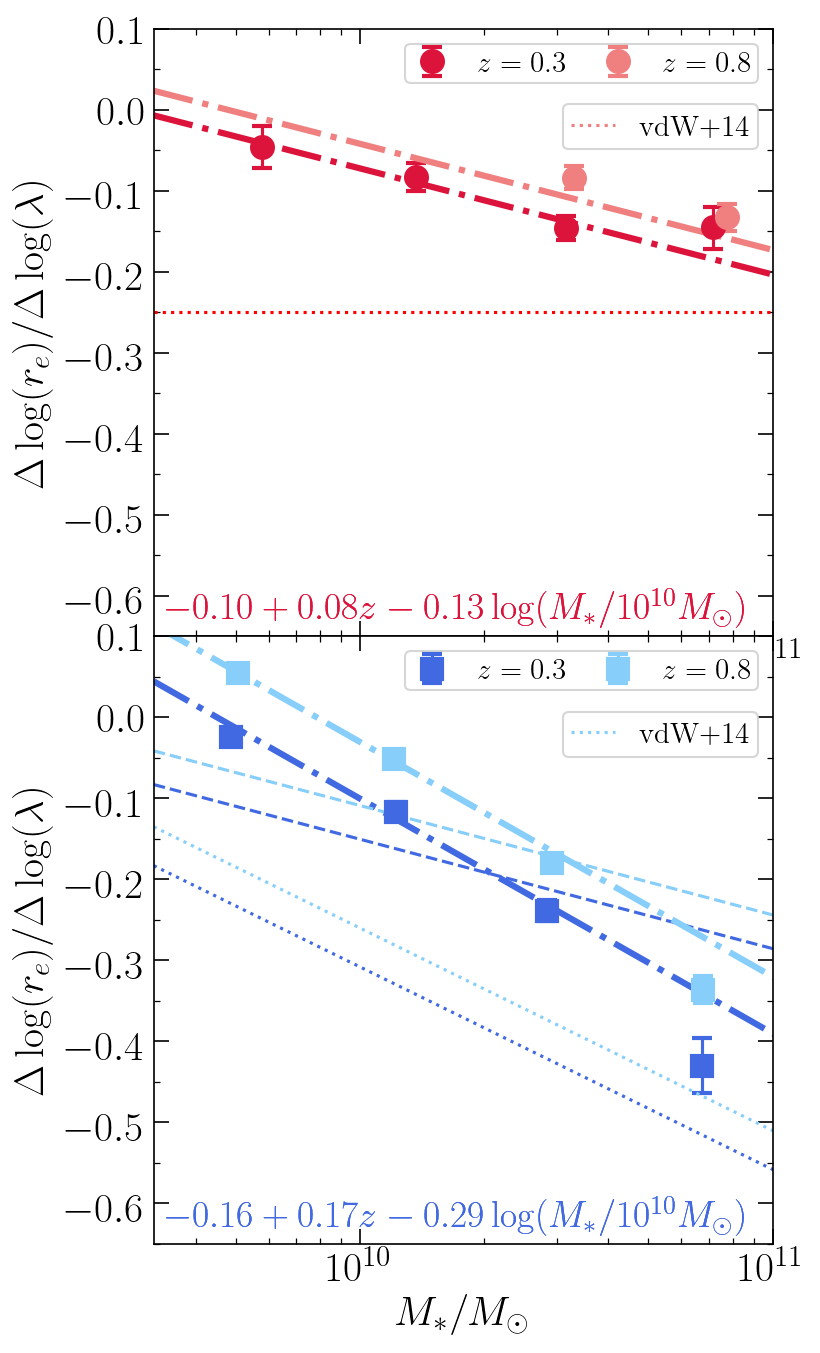

In [28]:
plot_colorgrad_v2(redshiftbins = np.array([0.2,0.5,1.0]),
                      plot_log=False,use_masscomplete=True,fit_option=2, apply_mask=False,
                 #subdir='logRe_loglambda_before_syserr_catastrophic')
                #subdir='logRe_loglambda_syserr_nocatastrophic')
                subdir='logRe_loglambda_syserr_catastrophic')

In [70]:
(data_mcomp_deep['mlim_func_qui'])(0.5)

array(8.99534216)

In [71]:
(data_mcomp_deep['mlim_func_qui'])(1)

array(10.01883221)